In [ ]:
# lagged ensemble modeling https://meetingorganizer.copernicus.org/EGU2020/EGU2020-2680.html

In [1]:
import argparse
import os
import sys
import time, re
import numpy as np
import logging
from datetime import datetime, timedelta
from collections import OrderedDict


username="gupt1075"
# sys.path.append(os.path.dirname(os.path.realpath(__file__)) + '/../')

if (f"/home/{username}/FourCastNet_gil" not in sys.path):
    sys.path.append(f"/home/{username}/FourCastNet_gil")





import h5py
import torch
import torch.cuda.amp as amp
import torch.distributed as dist
import torch.nn as nn
import torchvision
from numpy.core.numeric import False_
from torch.nn.parallel import DistributedDataParallel
from torchvision.utils import save_image
from utils import logging_utils
from utils.weighted_acc_rmse import (
    unweighted_acc_torch_channels,
    weighted_acc_masked_torch_channels,
    weighted_acc_torch_channels,
    weighted_rmse_torch_channels,
)

import glob
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import wandb
from networks.afnonet import AFNONet
from utils.data_loader_multifiles import get_data_loader
from utils.YParams import YParams
from scipy.stats import sem



/depot/gdsp/apps/FourCastNet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import h5py
import numpy as np
import sys, os



# era sst


import netCDF4
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
import matplotlib
from matplotlib import cm
import matplotlib.ticker as mticker
# import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# from matplotlib import animation
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
# plt.rcParams['animation.ffmpeg_path'] = '/home/gupt1075/FourCastNet/'


In [2]:
def plot_dynamic(data, fld="z500"):

    # fld="t850"
    channel_tags = {"u10": 0, "z500": 14, "2m_temperature": 2, "v10": 1, "t850": 5, "tcwv": 19}
    channel=channel_tags[fld]
    dim  = data.shape[0]
    # Calculate the number of rows and columns for the subplots
    num_rows = int(np.ceil(np.sqrt(dim)))
    num_cols = int(np.ceil(dim / num_rows))
    
    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, figsize=(24,12))
    
    # Iterate over the data and plot each array
    # plotting_datetime = datetime.strptime(date_str, '%Y_%B_%d_%H' )
    for i, ax in enumerate(axes.flat):
        if i < dim:
            # ax.imshow(data[i, channel], cmap='viridis')
            # ax = axs[i]
            ax.coastlines()
            out = ax.imshow(data[i, channel], cmap="coolwarm", origin='upper', extent=[0, 360, -90, 90],  transform=ccrs.PlateCarree())
            # ax.set_extent([minlon, maxlon, -45, 45], ccrs.PlateCarree())
            # ax.gridlines(draw_labels=True, crs=proj)
            ax.set_xticks([0, 60, 120, 180, 240, 300, 359.99], crs=ccrs.PlateCarree())
            ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
            fig.colorbar(out, ax=ax)
            # ax.set_title(f"{plotting_datetime}_field_{fld}")
    
            # ax.set_title(f'Subplot {i+1}')
            ax.axis('off')
        else:
            ax.axis('off')
    
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.tight_layout()
    # plt.title(f"{plotting_datetime}_field_{fld}")
    # Show the plot
    plt.show()

In [6]:
# fld = "z500"

def get_base_path_without_extension(global_path):
    """
    Extracts the base path of a file without the extension from a given global path.
    
    Args:
        global_path (str): The long global path of the file.
        
    Returns:
        str: The base path of the file without the extension.
    """
    # Get the base name of the file (without the directory path)
    base_name = os.path.basename(global_path)
    
    # Remove the file extension from the base name
    base_name_without_ext = os.path.splitext(base_name)[0]
    
    # Get the directory path of the file
    directory_path = os.path.dirname(global_path)
    
    # Combine the directory path and the base name without the extension
    base_path_without_ext = os.path.join(directory_path, base_name_without_ext)
    
    return base_path_without_ext


In [4]:

# ensemble_output_date_01_February_2018_ensemble_number_4
# Set the datetime format to search for in the filenames
datetime_format = '%Y_%B_%d_%H'

# Set the start and end dates to search for
start_date = datetime(2018, 1, 31, 0, 0, 0)
end_date = datetime(2018, 2, 7, 23, 59, 59)
directory = "/scratch/gilbreth/gupt1075/ERA5_ensemble_feb_5/afno_backbone/222/"

data_storage = []
filename_storage = []
# Loop through all files in the directory
for filename in os.listdir(directory):
    # Check if the file is a NumPy file
    if filename.endswith('.npy'):
        # Try to extract the datetime from the filename
        try:
            file_datetime = datetime.strptime(filename.split('.')[0], datetime_format)
            # Check if the file datetime is within the specified range
            if start_date <= file_datetime <= end_date:
                # Load the NumPy file
                file_path = os.path.join(directory, filename)
                data = np.load(file_path)
                print(f'Loaded file: {filename}')
                data_storage.append(data)
                filename_storage.append(filename)
                print(data.shape)
        except ValueError:
            # If the filename doesn't match the expected format, skip the file
            pass

Loaded file: 2018_February_07_18.npy
(3, 20, 720, 1440)
Loaded file: 2018_February_07_12.npy
(4, 20, 720, 1440)
Loaded file: 2018_February_05_06.npy
(1, 20, 720, 1440)
Loaded file: 2018_February_06_18.npy
(6, 20, 720, 1440)
Loaded file: 2018_February_06_12.npy
(6, 20, 720, 1440)
Loaded file: 2018_February_06_06.npy
(5, 20, 720, 1440)
Loaded file: 2018_February_05_18.npy
(3, 20, 720, 1440)
Loaded file: 2018_February_06_00.npy
(4, 20, 720, 1440)
Loaded file: 2018_February_07_00.npy
(6, 20, 720, 1440)
Loaded file: 2018_February_05_12.npy
(2, 20, 720, 1440)
Loaded file: 2018_February_07_06.npy
(5, 20, 720, 1440)


 plotting filename 2018_February_07_06  with shape (5, 20, 720, 1440)    


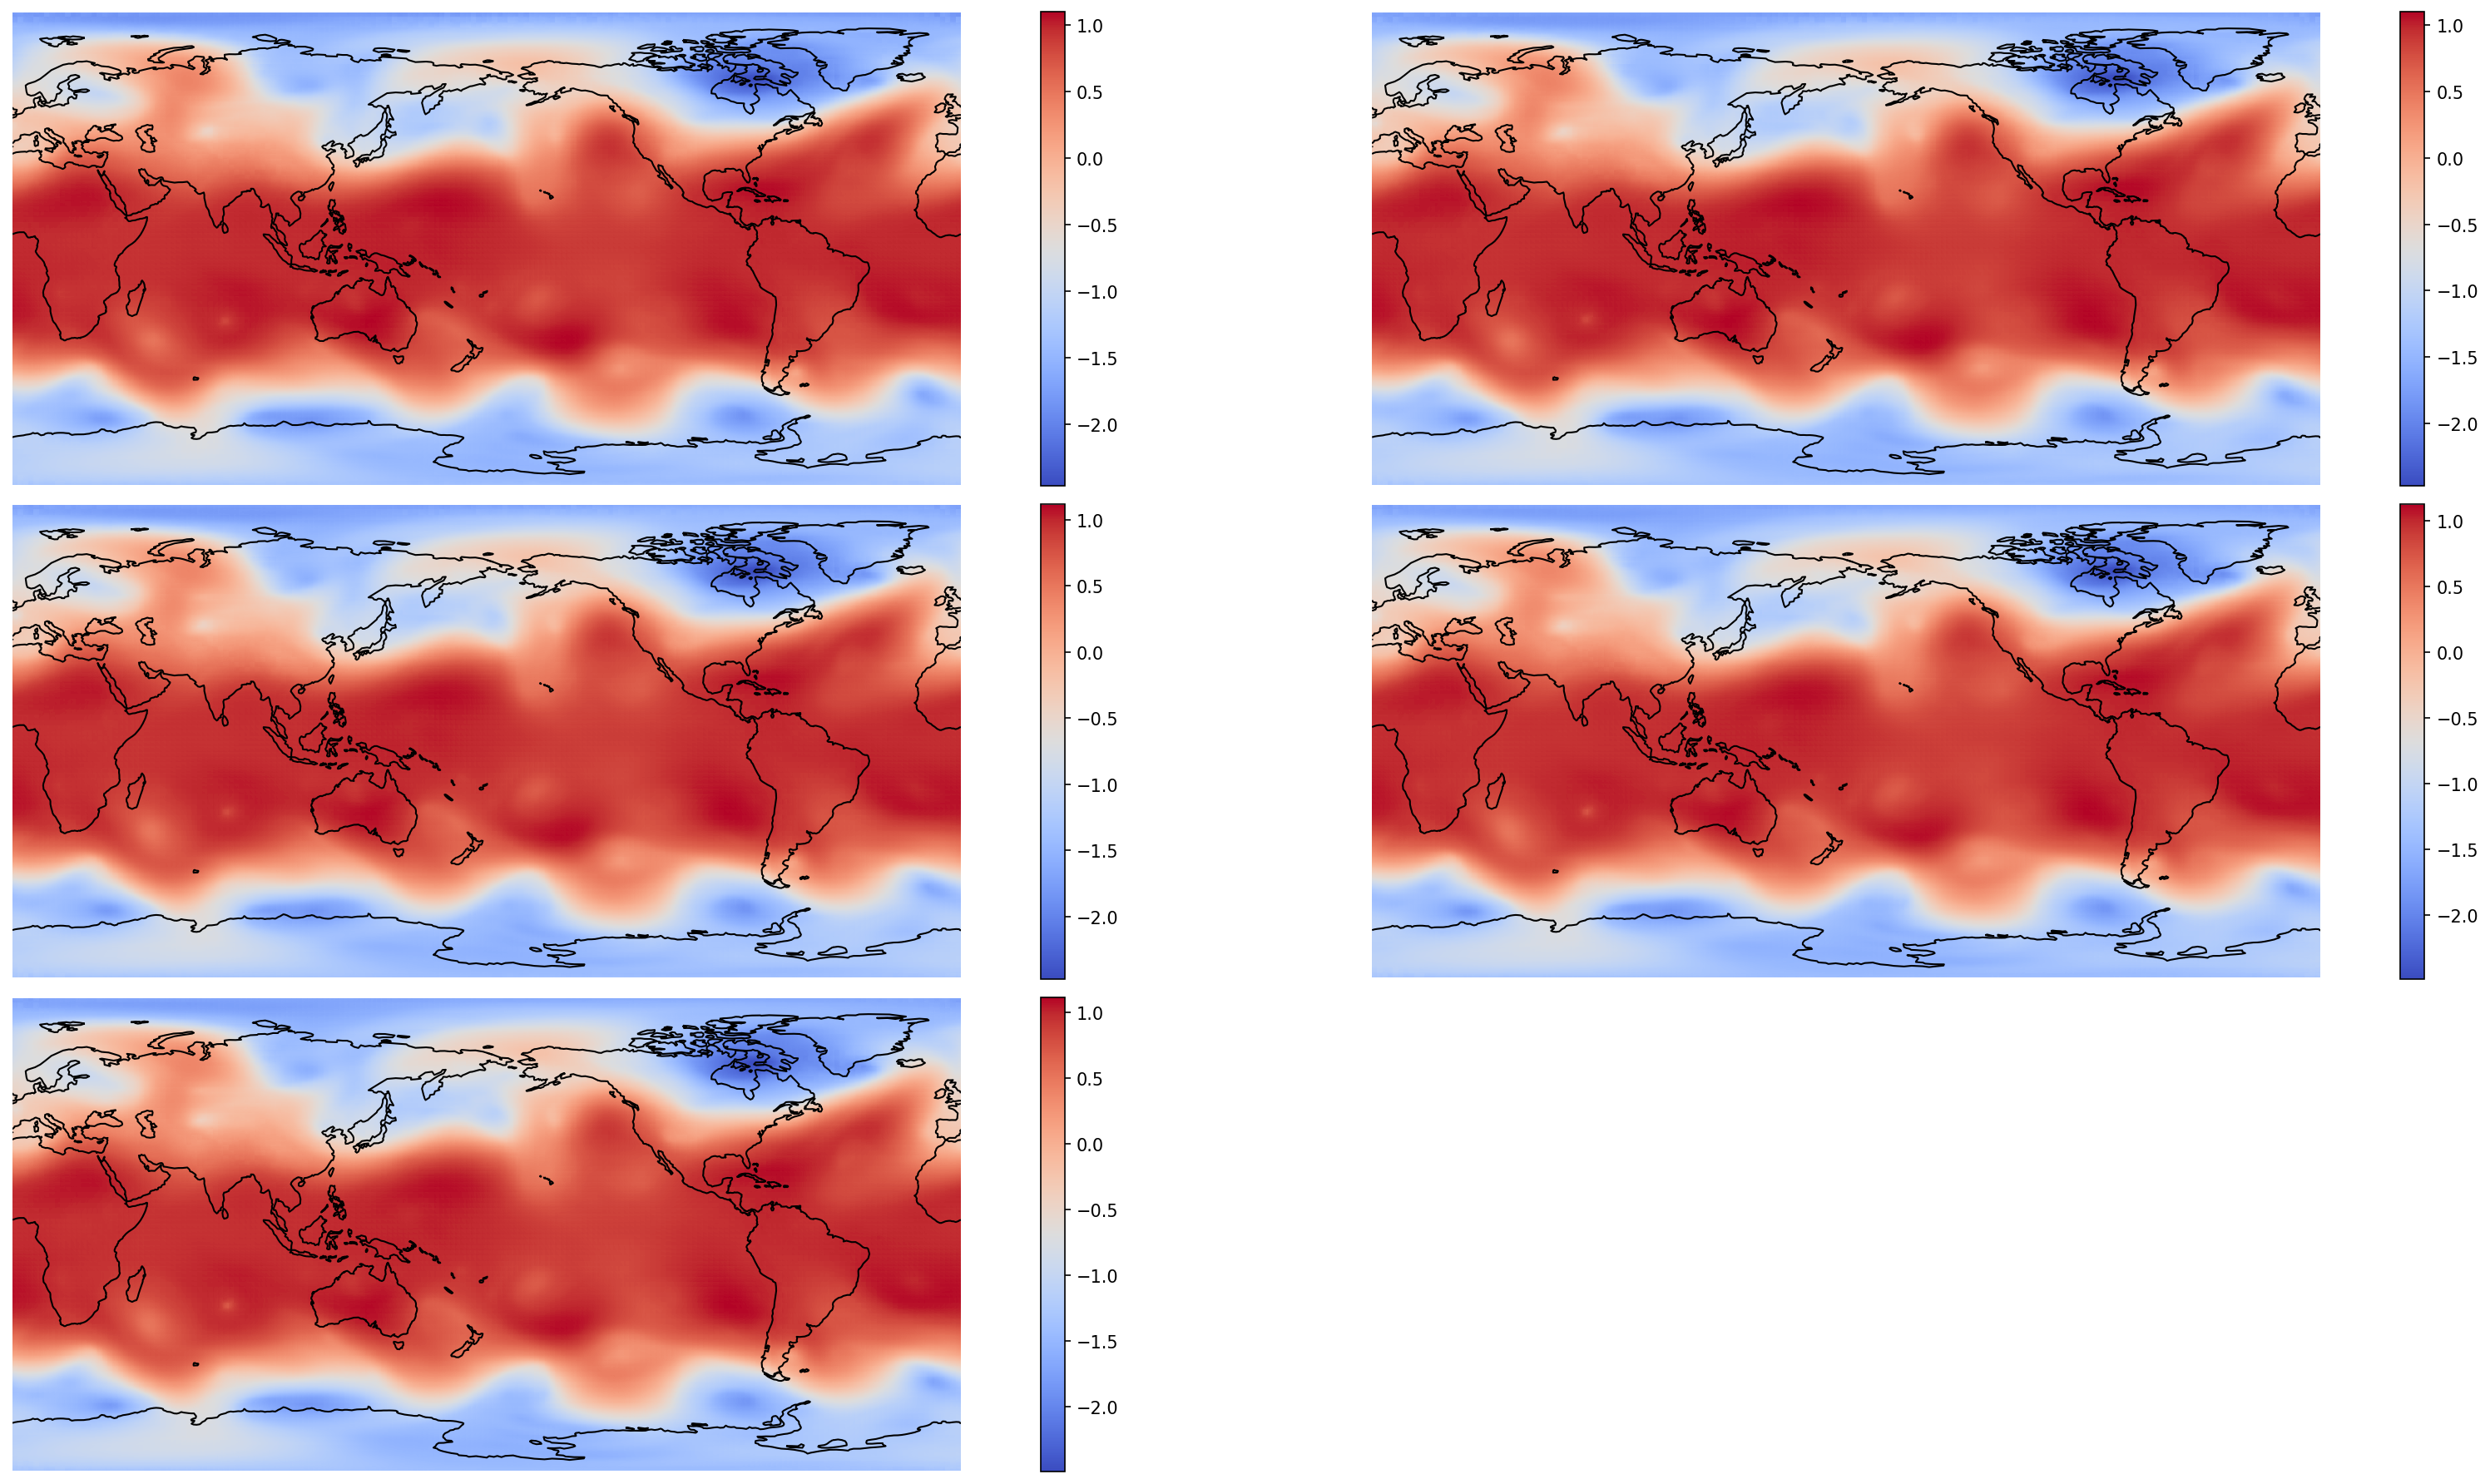

In [9]:

index_to_plot = 10


# filepath = "2018_February_07_18.npy"

filename = get_base_path_without_extension(filename_storage[index_to_plot])
print(f" plotting filename {filename}  with shape {data_storage[index_to_plot].shape}    " )

plot_data = data_storage[index_to_plot]
plot_dynamic(plot_data, fld="z500")